In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [5]:
df = pd.read_csv("/content/data.csv", parse_dates=["week"])
df = df.dropna(subset=['total_price'])
df = df.sort_values(by=['store_id', 'sku_id', 'week'])

<ipython-input-5-57edc5981003>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("/content/data.csv", parse_dates=["week"])


In [6]:
for lag in [1, 2, 3]:
    df[f'units_sold_lag_{lag}'] = df.groupby(['store_id', 'sku_id'])['units_sold'].shift(lag)
df = df.dropna()

In [9]:
features = ['units_sold_lag_1', 'units_sold_lag_2', 'units_sold_lag_3']
target = 'units_sold'

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [10]:

X_scaled = scaler_X.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

In [11]:
X = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
y = y_scaled

# Train-test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [12]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(1, X.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 2.8474e-04 - val_loss: 2.5159e-04
Epoch 2/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 2.3964e-04 - val_loss: 2.4675e-04
Epoch 3/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 2.4575e-04 - val_loss: 2.5425e-04
Epoch 4/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 2.5015e-04 - val_loss: 2.4745e-04
Epoch 5/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 2.5906e-04 - val_loss: 2.5383e-04
Epoch 6/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 2.5871e-04 - val_loss: 2.4626e-04
Epoch 7/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 2.5768e-04 - val_loss: 2.4268e-04
Epoch 8/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.5692e-04 - val_loss: 2.5508e-04
Epoch 9/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.3790e-04 - val_loss: 2.4787e-04
Epoch 10/50
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 2.4519e-04 - val_loss: 2.4346e-04
Epoch 11/50
1467/1467 ━━━━━━━━━━━━━━━━

In [14]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
MAE: 25.32
RMSE: 56.86
R² Score: 0.3458


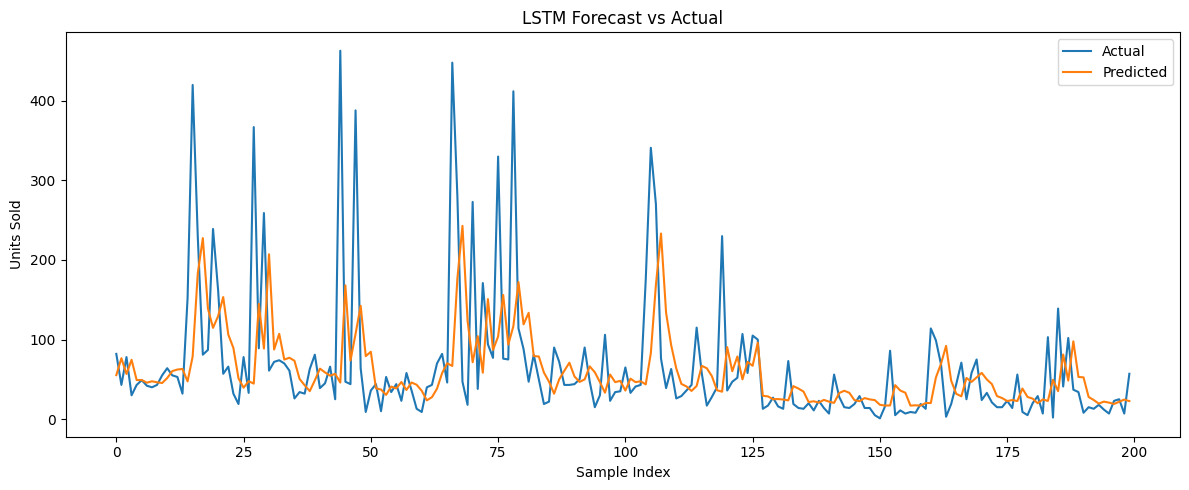

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(y_true[:200], label='Actual')
plt.plot(y_pred[:200], label='Predicted')
plt.title("LSTM Forecast vs Actual")
plt.xlabel("Sample Index")
plt.ylabel("Units Sold")
plt.legend()
plt.tight_layout()
plt.show()